<a href="https://colab.research.google.com/github/DevD231204/DevD231204/blob/main/Steganography.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!pip install pycryptodome opencv-python

In [12]:
import cv2
import numpy as np
import hashlib
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad
from Crypto.Random import get_random_bytes
from IPython.display import Image, display

# ===== AES UTILITY FUNCTIONS =====
def derive_key(password):
    return hashlib.sha256(password.encode()).digest()[:16]  # AES-128

def encrypt_message(msg, password):
    key = derive_key(password)
    cipher = AES.new(key, AES.MODE_CBC)
    ct = cipher.encrypt(pad(msg.encode(), AES.block_size))
    return cipher.iv + ct  # Prepend IV
# ==================================

def bytes_to_bits(data):
    return [((byte >> i) & 1) for byte in data for i in range(7, -1, -1)]

def embed_bits(image, bits):
    flat = image.flatten()
    if len(bits) > len(flat):
        raise ValueError("Image not large enough to hold message.")

    for i in range(len(bits)):
        flat[i] = (flat[i] & 0xFE) | bits[i]  # Replace LSB
    return flat.reshape(image.shape)

# === MAIN EMBED FUNCTION ===
def embed_message_in_image(image_path, secret_message, password, output_path="lsb_encrypted.png"):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    encrypted = encrypt_message(secret_message, password)
    msg_len = len(encrypted)
    print(f"Encrypted Length: {msg_len} bytes")

    # Store message length in first 32 bits
    len_bits = [int(b) for b in format(msg_len, '032b')]
    msg_bits = bytes_to_bits(encrypted)
    full_bits = len_bits + msg_bits

    stego_img = embed_bits(img_rgb.copy(), full_bits)
    cv2.imwrite(output_path, cv2.cvtColor(stego_img, cv2.COLOR_RGB2BGR))
    display(Image("lsb_encrypted.png"))
    print(f"Encrypted message embedded in '{output_path}'")


In [13]:
from Crypto.Util.Padding import unpad

def decrypt_message(ciphertext_with_iv, password):
    key = derive_key(password)
    iv = ciphertext_with_iv[:16]
    ct = ciphertext_with_iv[16:]
    cipher = AES.new(key, AES.MODE_CBC, iv)
    return unpad(cipher.decrypt(ct), AES.block_size).decode()

def extract_bits(image, num_bits):
    flat = image.flatten()
    return [(flat[i] & 1) for i in range(num_bits)]

def bits_to_bytes(bits):
    return bytes([sum([bits[i*8 + j] << (7 - j) for j in range(8)]) for i in range(len(bits)//8)])

# === MAIN EXTRACT FUNCTION ===
def extract_message_from_image(stego_path, password):
    img = cv2.imread(stego_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Get message length from first 32 bits
    len_bits = extract_bits(img_rgb, 32)
    msg_len = int("".join(map(str, len_bits)), 2)
    print(f"Extracted Encrypted Length: {msg_len} bytes")

    # Extract message bits
    msg_bits = extract_bits(img_rgb, 32 + msg_len * 8)[32:]
    encrypted_bytes = bits_to_bytes(msg_bits)

    # Decrypt
    try:
        plain_text = decrypt_message(encrypted_bytes, password)
        print("\nDecrypted message:", plain_text)
    except Exception as e:
        print("\nDecryption failed:", str(e))


Encrypted Length: 48 bytes


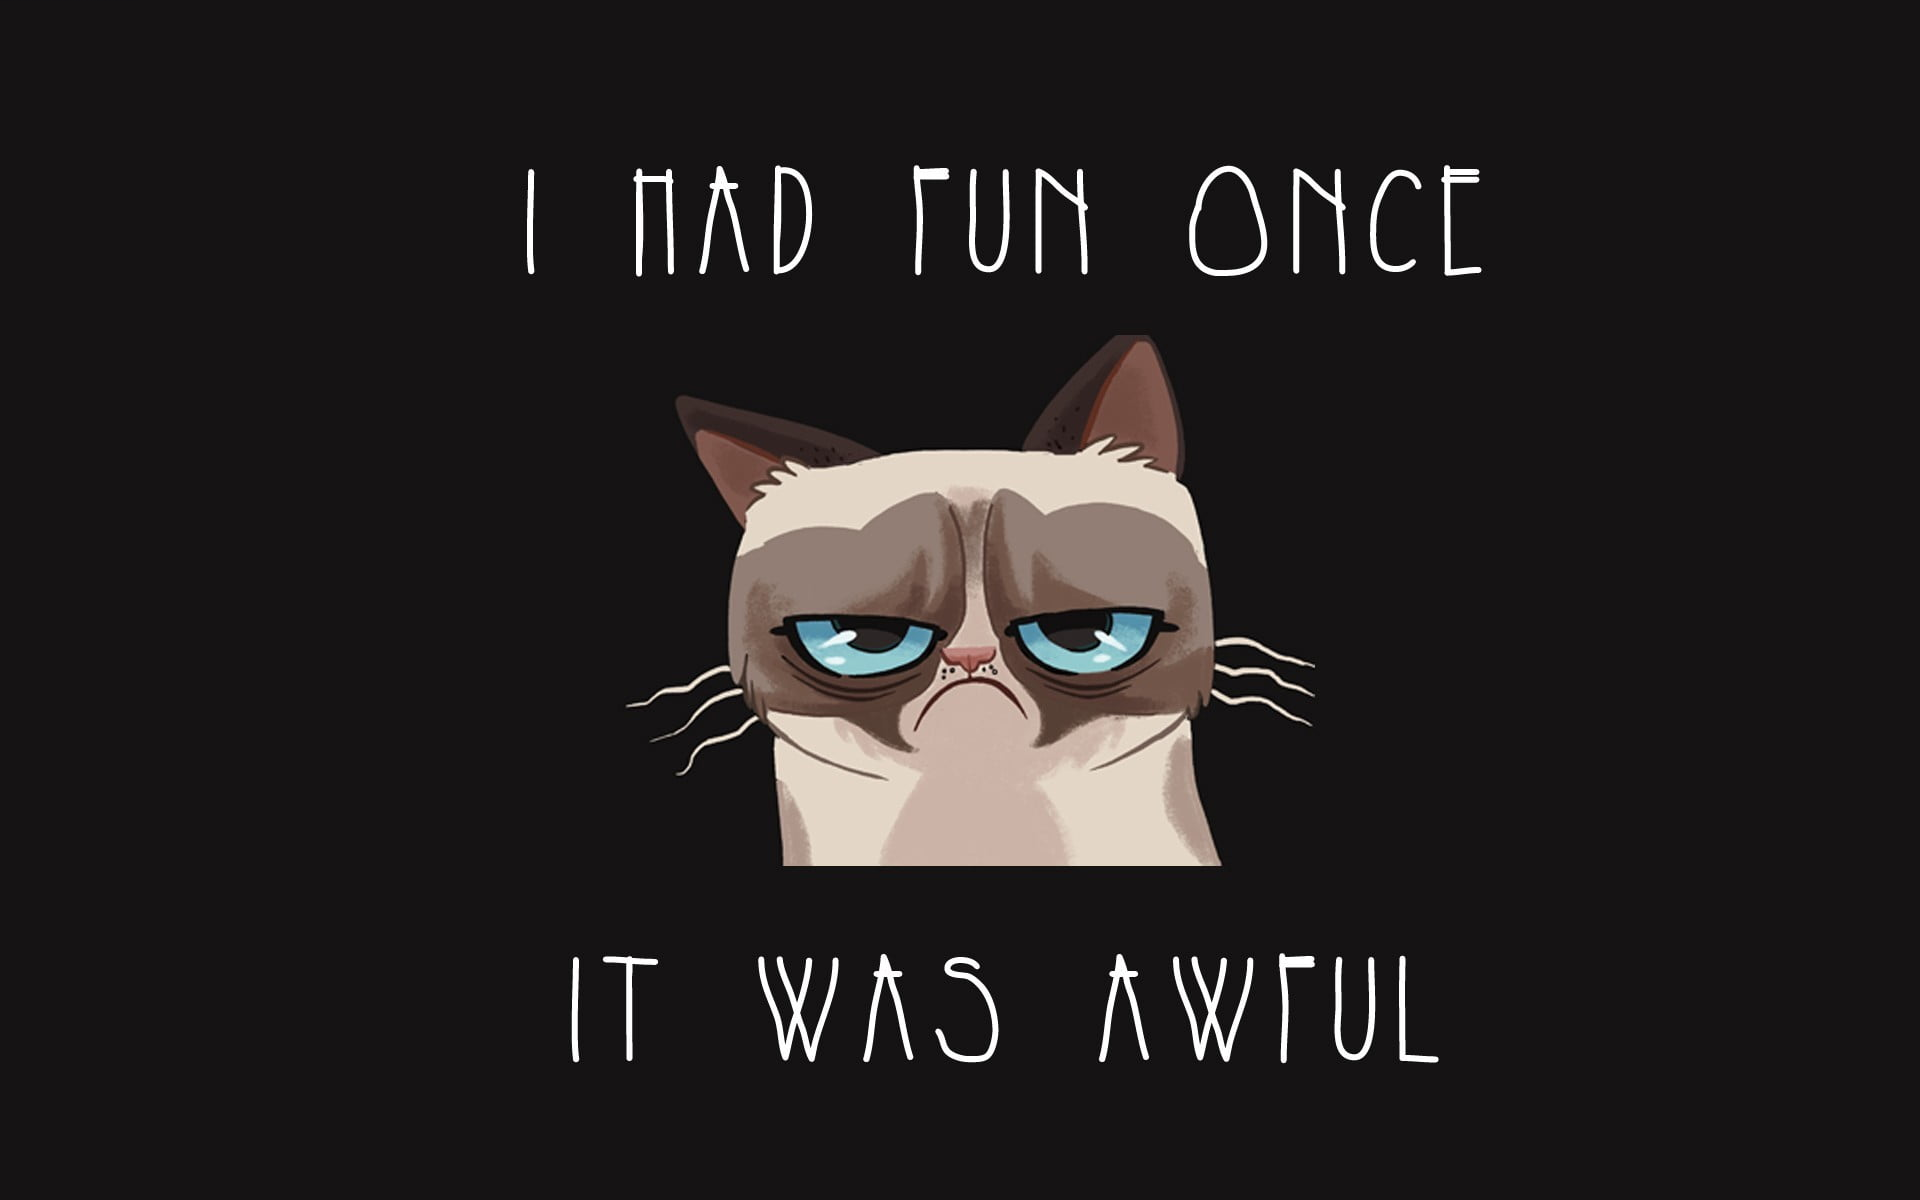

Encrypted message embedded in 'lsb_encrypted.png'
Extracted Encrypted Length: 48 bytes

Decrypted message: Hello, this is secret.


In [14]:
# Hide message
embed_message_in_image("/content/wallpaperflare.com_wallpaper (5).jpg", "Hello, this is secret.", "my_password")

# Extract + Decrypt
extract_message_from_image("lsb_encrypted.png", "my_password")
